In [315]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import mpmath as mp
mp.dps = 500
from sklearn.linear_model import Lasso


In [316]:
def gen_data(n, p):
    X = np.random.normal(0, 1, (n, p))
    beta = np.zeros(p)
    y = X @ beta.T + np.random.normal(0, 1, n)
    return X, y, beta

def check_KKT(XA, XAc, y, bhA, lamda, n):

    print("\nCheck Active")
    e1 = y - np.dot(XA, bhA)
    print(XA.shape)
    print(bhA.shape)
    e2 = np.dot(XA.T, e1)
    print(e2/ (lamda * n))

    if XAc is not None:
        print("\nCheck In Active")
        e1 = y - np.dot(XA, bhA)
        e2 = np.dot(XAc.T, e1)
        print(e2/ (lamda * n))

def preprocess(x, coef):
    A = np.where(coef != 0)[0]
    I = np.where(coef == 0)[0]
    xA = x[:, A]
    xI = x[:, I]
    coefA = coef[A]
    coefI = coef[I]
    A = A.reshape(-1, 1)
    I = I.reshape(-1, 1)
    xA = xA.reshape(xA.shape[0], xA.shape[1])
    xI = xI.reshape(xI.shape[0], xI.shape[1])
    coefA = coefA.reshape(coefA.shape[0], 1)
    coefI = coefI.reshape(coefI.shape[0], 1)
    return A, I, xA, xI, coefA, coefI

def compute_etaj_etajTy(j_selected, active, active_X, y):    
    ej = []
    for each_j in active:
        if j_selected == each_j:
            ej.append(1)
        else:
            ej.append(0)

    ej = np.array(ej).reshape((len(active), 1))

    etaj = np.linalg.pinv(active_X).T @ ej
    # print(etaj.shape)
    etajTy = np.dot(etaj.T, y)[0]

    return etaj, etajTy

def compute_a_b(n, etaj, cov, y):
    b = cov @ etaj @ np.linalg.pinv(etaj.T @ cov @ etaj)
    a = (np.identity(n) - b @ etaj.T) @ y 
    a = a.reshape((n, 1))
    return a, b

def compute_quotient(numerator, denominator):
    if denominator == 0:
        return np.Inf

    quotient = numerator / denominator

    if quotient <= 0:
        return np.Inf

    return quotient

def compute_step_size(x, yz, Lambda, b):
    n = x.shape[0]
    lasso1 = Lasso(alpha=Lambda, fit_intercept=False, max_iter=10000000)
    lasso1.fit(x, yz)
    bhz = lasso1.coef_
    shz = np.sign(bhz)
    Az = np.where(bhz != 0)[0]
    Acz = np.where(bhz == 0)[0]
    bhAz = bhz[Az]
    xAz = x[:, Az]
    xAcz = x[:, Acz]
    xIz = x[:, Acz]

    bhAz = bhAz.reshape(bhAz.shape[0], 1)
    yz = yz.reshape(yz.shape[0], 1)
    
    # check_KKT(xAz, xIz, yz, bhAz, Lambda, n)

    etaAz = np.array([])

    if (xAz is not None):
        inv = np.linalg.pinv(np.dot(xAz.T, xAz))
        invXAzT = np.dot(inv, xAz.T)
        etaAz = np.dot(invXAzT, b)

    t1z = np.Inf
    t2z = np.Inf

    shAz = np.array([])
    gammaAz = np.array([])
    
    if xAcz is not None:
        if xAz is None:
            e1 = yz
        else:
            e1 = yz - np.dot(xAz, bhAz)

        e2 = np.dot(xAcz.T, e1)
        shAz = e2/(Lambda * n)

        if xAz is None:
            gammaAz = (np.dot(xAcz.T, b)) / n
        else:
            gammaAz = (np.dot(xAcz.T, b) - np.dot(np.dot(xAcz.T, xAz), etaAz)) / n
    
    bhAz = bhAz.flatten()
    etaAz = etaAz.flatten()
    shAz = shAz.flatten()
    gammaAz = gammaAz.flatten()

    for j in range(len(Az)):
        numerator = -bhAz[j]
        denominator = etaAz[j]
        quotient = compute_quotient(numerator, denominator)
        if quotient < t1z:
            t1z = quotient

    for j in range(len(Acz)):
        numerator = Lambda * (np.sign(gammaAz[j]) - shAz[j])
        denominator = gammaAz[j]
        quotient = compute_quotient(numerator, denominator)
        if quotient < t2z:
            t2z = quotient
    tzk = min(t1z, t2z)
    return tzk, bhz, Az

def compute_yz(y, etaj, zk, n):
    sq_norm = (np.linalg.norm(etaj))**2

    e1 = np.identity(n) - (np.dot(etaj, etaj.T))/sq_norm
    a = np.dot(e1, y)

    b = etaj/sq_norm

    yz = a + b*zk

    return yz, b

def compute_solution_path(x, y, Lambda, etaj, n):
    k = 0
    zmin = -20
    zmax = 20
    z = zmin 
    bhz = []
    ahz = []
    z_interval = []
    while (z < zmax):
        yz, b = compute_yz(y, etaj, z, n)
        tzk, bhzk, ahzk = compute_step_size(x, yz, Lambda, b)
        z_interval.append(min(z, zmax))
        tzk = tzk
        z = z + tzk + 1e-6
        bhz.append(bhzk)
        ahz.append(ahzk)
    z_interval.append(min(z, zmax))
    return bhz, ahz, z_interval

def compute_cdf(mu, sigma, l, r):
    true_cdf = mp.ncdf((r - mu) / sigma) - mp.ncdf((l - mu) / sigma)
    return true_cdf

def cdf(z_interval, ahz, A, mu, sigma, etajTy):
    numerator = 0
    A = A.flatten()
    etajTy = etajTy[0]

    for i in range(len(z_interval) - 1):
        l = z_interval[i]
        r = z_interval[i+1] - 1e-6
        if (np.array_equal(ahz[i], A) == False):
            continue
        if r < etajTy:
            numerator += compute_cdf(mu, sigma, l, r)
        elif l <= etajTy and etajTy < r:
            numerator += compute_cdf(mu, sigma, l, etajTy)
    demoninator = 0
    for i in range(len(z_interval) - 1):
        l = z_interval[i]
        r = z_interval[i+1] - 1e-6
        if (np.array_equal(ahz[i], A) == False):
            continue
        demoninator += compute_cdf(mu, sigma, l, r)
    # print('numerator:', numerator)
    # print('denominator:', demoninator)
    if demoninator <= 1e-16:
        true_cdf = 1
    else:
        true_cdf = numerator / demoninator 
    return true_cdf

def run():
    np.random.seed(0)
    n = 100
    p = 5
    x, y, true_beta = gen_data(n, p)
    y = y.reshape(y.shape[0], 1)
    true_y = x @ true_beta
    Lambda = 5
    Lambda /= n
    cov = np.identity(n)
    lasso = Lasso(alpha=Lambda, fit_intercept=False, max_iter=100000)  
    lasso.fit(x, y)
    coef = lasso.coef_
    # print(coef)
    A, I, xA, xI, coefA, coefI = preprocess(x, coef)
    print('observed active set:', A)
    check_KKT(xA, xI, y, coefA, Lambda, n)
    if (len(A) == 0):
        return None
    rand_value = np.random.randint(len(A))
    j = A[rand_value]
    etaj, etajTy = compute_etaj_etajTy(j, A, xA, y)
    print('etajTy:', etajTy)
    bhz, ahz, z_interval = compute_solution_path(x, y, Lambda, etaj, n)
    for i in range(len(z_interval) - 1):
        l = z_interval[i]
        r = z_interval[i+1] - 1e-6
        
        print(f'z_interval: {l} - {r}')
        print('active set:', ahz[i])
    mu = (etaj.T @ true_y)[0]
    sigma = np.sqrt((etaj.T @ cov @ etaj))[0][0]
    if (sigma == 0):
        print(sigma)
    # print('sigma:', sigmaz)
    my_cdf = cdf(z_interval, ahz, A, mu, sigma, etajTy)
    print('my_cdf:', my_cdf)
    p_value = 2 * min(1 - my_cdf, my_cdf)
    return p_value

observed active set: [[1]
 [2]
 [4]]

Check Active
(100, 3)
(3, 1)
[[ 1.00000998]
 [ 1.00000134]
 [-1.        ]]

Check In Active
[[ 0.8644337 ]
 [-0.00436442]]
etajTy: [0.22263543]
z_interval: -20 - -2.5139736105157695
active set: [1 2 4]
z_interval: -2.5139726105157694 - -2.51397043997798
active set: [1 2 4]
z_interval: -2.5139694399779797 - -1.971613627701064
active set: [1 2]
z_interval: -1.9716126277010642 - -0.9252774811604794
active set: [0 1 2]
z_interval: -0.9252764811604793 - -0.45418921914466215
active set: [0 2]
z_interval: -0.4541882191446622 - -0.04336226597402576
active set: [0 2 4]
z_interval: -0.04336126597402576 - -0.009013943801155555
active set: [0 4]
z_interval: -0.009012943801155556 - 0.05775744331895112
active set: [4]
z_interval: 0.05775844331895112 - 0.168037533263319
active set: [2 4]
z_interval: 0.168038533263319 - 9.44210292087008
active set: [2 4]
z_interval: 9.44210392087008 - 19.999999
active set: [1 2 4]
my_cdf: 1
pvalue0: 0.0


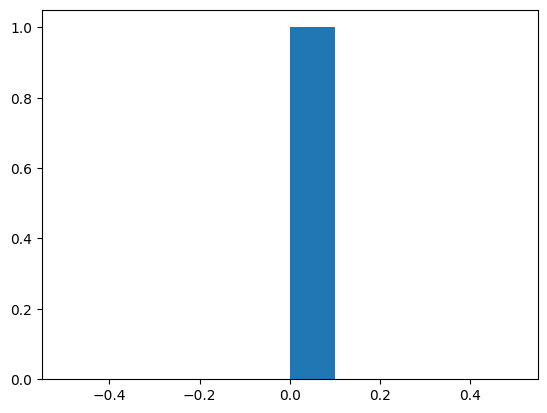

In [319]:
list_pval = []
for _ in range(1):
    pvalue = run()
    if (pvalue != None):
        list_pval.append(float(pvalue))
    print(f"pvalue{_}:", list_pval[-1])
# print(list_pval)
plt.hist(list_pval)
plt.show()


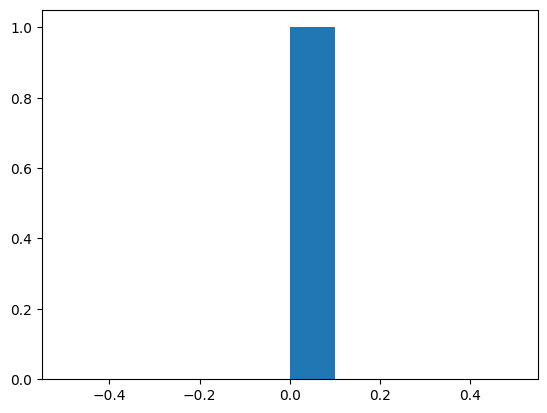

In [318]:
plt.hist(list_pval)
plt.show()